# 03_06_debugging.ipynb - Debugging  with ipdb

In [1]:
import math

In [2]:
import numpy as np
import scipy
import scipy.integrate as si
import matplotlib.pyplot as pp

In [3]:
import astropy
import astropy.time
import astropy.coordinates
import astropy.units
import astropy.constants

In [4]:
# IAU 2012 values from from http://maia.usno.navy.mil/NSFA/NSFA_cbe.html

bodies = ['sun','mercury','venus','earth','mars','jupiter','saturn','uranus','neptune']

# dictionary of masses
massdict = {'sun': 1.0,
            'mercury': 1.6601209949637026e-07,
            'venus': 2.4478382857373332e-06,
            'earth': 3.0034896946063695e-06,
            'mars': 3.227156037857755e-07,
            'jupiter': 0.0009547918983127075,
            'saturn': 0.00028588567008942334,
            'uranus': 4.3662495719438076e-05,
            'neptune': 5.151383713179197e-05}

# array of masses
masses = np.array([massdict[body] for body in bodies])

In [5]:
G = astropy.constants.G.to('AU^3 / (Msun d^2)')

In [6]:
t0, t1 = astropy.time.Time('2021-07-04'), astropy.time.Time('2031-07-04')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [7]:
def get_posvel(body, t):
    posvel = astropy.coordinates.get_body_barycentric_posvel(body, t)
    
    return np.hstack([posvel[0].xyz.value.T, posvel[1].xyz.value.T])

In [8]:
y0 = np.array([get_posvel(body, t0) for body in bodies])

In [9]:
def ydot(t, y):
    # how many bodies? make sure the answer is an integer
    n = int(y.shape[0] / 6)

    # make an empty container for the derivatives
    yd = np.zeros_like(y)
    
    # for each body
    for i in range(n):
        # set x_i' = v_i (array slice assignment)
        yd[i*6:i*6+3] = y[i*6+3:i*6+6]
        
        # loop over all other bodies
        for j in range(n):
            if i == j:
                continue

            # add contribution of planet j to v_i'
            rij = y[j*6:j*6+3] - y[i*6:i*6+3]
            yd[i*6+3:i*6+6] += G * masses[j] * rij / np.dot(rij,rij)
    
    return yd

In [10]:
ydot(t0, y0)

array([[ 2.02987462e-01, -9.08236814e-01, -3.93560929e-01,
         1.65489414e-02,  3.20200963e-03,  1.38765895e-03],
       [-1.48108634e+00,  6.94567945e-01,  3.58383718e-01,
        -5.99579632e-03, -1.02388807e-02, -4.53432074e-03],
       [ 4.00222927e+00, -2.76183300e+00, -1.28120815e+00,
         4.47340372e-03,  5.88774592e-03,  2.41491048e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.000

In [11]:
ydot(t0, y0).shape

(9, 6)

In [12]:
%debug ydot(t0, y0)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> where
  /opt/homebrew/anaconda3/lib/python3.10/bdb.py(597)run()
    595         sys.settrace(self.trace_dispatch)
    596         try:
--> 597             exec(cmd, globals, locals)
    598         except BdbQuit:
    599             pass

> <string>(1)<module>()

ipdb> s
--Call--
> /var/folders/92/kq20538s5739pr_h825t9fr80000gn/T/ipykernel_19197/1240929440.py(1)ydot()
----> 1 def ydot(t, y):
      2     # how many bodies? make sure the answer is an integer
      3     n = int(y.shape[0] / 6)
      4 
      5     # make an empty container for the derivatives

ipdb> n
> /var/folders/92/kq20538s5739pr_h825t9fr80000gn/T/ipykernel_19197/1240929440.py(3)ydot()
      1 def ydot(t, y):
      2     # how many bodies? make sure the answer is an integer
----> 3     n = int(y.shape[0] / 6)
      4 
      5     # make an empty container for the derivatives

ipdb> n
> /var/folders/92/kq20538s5739pr_h825t9fr80

In [13]:
y0 = np.array([get_posvel(body, t0) for body in bodies]).flatten()

In [14]:
y0.shape

(54,)

In [15]:
ydot(t0, y0)

UnitTypeError: Cannot store quantity with dimension resulting from add function in a non-Quantity instance.

In [16]:
%debug

> /opt/homebrew/anaconda3/lib/python3.10/site-packages/astropy/units/quantity_helper/converters.py(357)check_output()
    355         # output is not a Quantity, so cannot obtain a unit.
    356         if not (unit is None or unit is dimensionless_unscaled):
--> 357             raise UnitTypeError("Cannot store quantity with dimension "
    358                                 "{}in a non-Quantity instance."
    359                                 .format("" if function is None else

ipdb> u
> /opt/homebrew/anaconda3/lib/python3.10/site-packages/astropy/units/quantity.py(600)__array_ufunc__()
    598             if function.nout == 1:
    599                 out = out[0]
--> 600             out_array = check_output(out, unit, inputs, function=function)
    601             # Ensure output argument remains a tuple.
    602             kwargs['out'] = (out_array,) if function.nout == 1 else out_array

ipdb> u
> /var/folders/92/kq20538s5739pr_h825t9fr80000gn/T/ipykernel_19197/1240929440.py

In [17]:
G = astropy.constants.G.to('AU^3 / (Msun d^2)').value

In [18]:
ydot(t0, y0)

array([-5.37208312e-06, -6.78869467e-06, -2.74086332e-06,  5.02473193e-08,
       -3.71030826e-08, -1.70928677e-08,  7.64683753e-03,  2.34128294e-02,
        1.17147635e-02, -6.62020487e-04,  2.85884258e-04,  2.21347859e-04,
       -4.87851687e-03, -1.81284422e-02, -7.84836656e-03,  3.99140767e-04,
       -7.92214755e-05, -6.08978927e-05,  1.65489414e-02,  3.20200963e-03,
        1.38765895e-03, -6.02697693e-05,  2.61200962e-04,  1.13228022e-04,
       -5.99579632e-03, -1.02388807e-02, -4.53432074e-03,  1.57202465e-04,
       -7.36553584e-05, -3.80251438e-05,  4.47340372e-03,  5.88774592e-03,
        2.41491048e-03, -4.67486385e-05,  3.22405733e-05,  1.49568561e-05,
        4.01771778e-03,  3.28490808e-03,  1.18343119e-03, -1.87195227e-05,
        2.11070415e-05,  9.52475028e-06, -2.61268197e-03,  2.52830320e-03,
        1.14446928e-03, -1.13008812e-05, -9.09797432e-06, -3.82467953e-06,
        4.59208334e-04,  2.88331279e-03,  1.16863815e-03, -9.78126904e-06,
        1.33557017e-06,  

In [19]:
orbits = scipy.integrate.solve_ivp(ydot, [t0.mjd, t1.mjd], y0, rtol=1e-9, atol=1e-9)

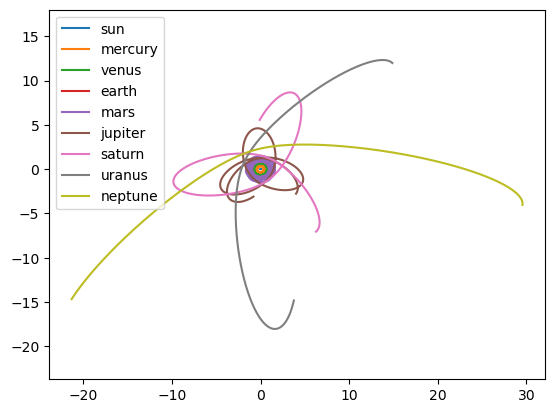

In [20]:
for i in range(9):
    pp.plot(orbits.y[i*6,:], orbits.y[i*6+1,:], label=bodies[i])

pp.legend()
pp.axis('equal');

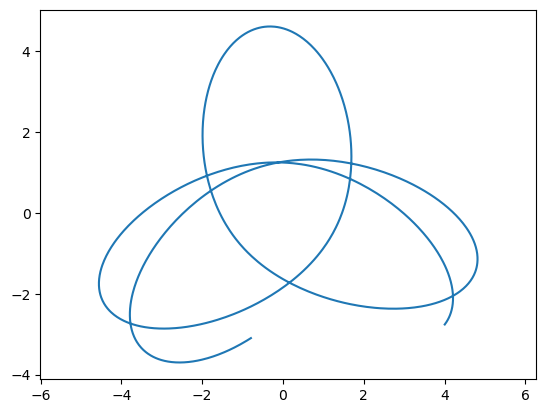

In [21]:
pp.plot(orbits.y[5*6,:], orbits.y[5*6+1,:])
pp.axis('equal');

In [ ]:
def ydot(t, y):
    # how many bodies? make sure the answer is an integer
    n = int(y.shape[0] / 6)

    # make an empty container for the derivatives
    yd = np.zeros_like(y)
    
    # for each body
    for i in range(n):
        # set x_i' = v_i (array slice assignment)
        yd[i*6:i*6+3] = y[i*6+3:i*6+6]
        
        # loop over all other bodies
        for j in range(n):
            if i == j:
                continue

            # add contribution of planet j to v_i'
            rij = y[j*6:j*6+3] - y[i*6:i*6+3]
            yd[i*6+3:i*6+6] += G * masses[j] * rij / np.dot(rij,rij)
    
    return yd

In [23]:
%debug ydot(t0, y0)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> p G
0.00029591220819207774
ipdb> q


In [24]:
def ydot(t, y):
    # how many bodies? make sure the answer is an integer
    n = int(y.shape[0] / 6)

    # make an empty container for the derivatives
    yd = np.zeros_like(y)
    
    # for each body
    for i in range(n):
        # set x_i' = v_i (array slice assignment)
        yd[i*6:i*6+3] = y[i*6+3:i*6+6]
        
        # loop over all other bodies
        for j in range(n):
            if i == j:
                continue

            # add contribution of planet j to v_i'
            rij = y[j*6:j*6+3] - y[i*6:i*6+3]
            yd[i*6+3:i*6+6] += G * masses[j] * rij / np.dot(rij,rij)**1.5
    
    return yd

In [25]:
orbits = scipy.integrate.solve_ivp(ydot, [t0.mjd, t1.mjd], y0, rtol=1e-9, atol=1e-9)

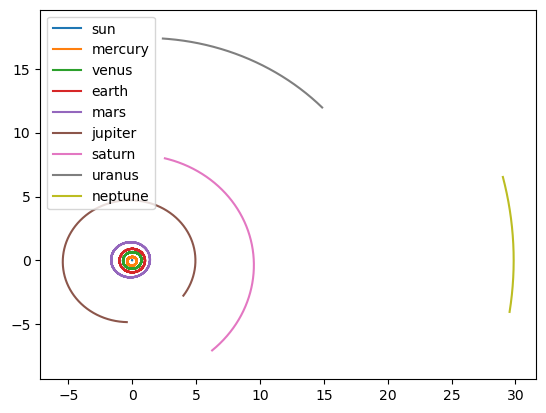

In [26]:
for i in range(9):
    pp.plot(orbits.y[i*6,:], orbits.y[i*6+1,:], label=bodies[i])

pp.legend()
pp.axis('equal');

In [ ]:
%debug

> /opt/homebrew/anaconda3/lib/python3.10/site-packages/astropy/units/quantity_helper/converters.py(357)check_output()
    355         # output is not a Quantity, so cannot obtain a unit.
    356         if not (unit is None or unit is dimensionless_unscaled):
--> 357             raise UnitTypeError("Cannot store quantity with dimension "
    358                                 "{}in a non-Quantity instance."
    359                                 .format("" if function is None else

ipdb> h

Documented commands (type help <topic>):
EOF    commands   enable    ll        pp       s                until 
a      condition  exit      longlist  psource  skip_hidden      up    
alias  cont       h         n         q        skip_predicates  w     
args   context    help      next      quit     source           whatis
b      continue   ignore    p         r        step             where 
break  d          interact  pdef      restart  tbreak         
bt     debug      j         pdoc      retur